## Setting up environment

In [1]:
!git clone https://github.com/Kangningthu/DeepDenoisingGuide

Cloning into 'DeepDenoisingGuide'...
remote: Enumerating objects: 869, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 869 (delta 27), reused 123 (delta 22), pack-reused 739 (from 1)
Receiving objects: 100% (869/869), 337.62 MiB | 21.92 MiB/s, done.
Resolving deltas: 100% (55/55), done.
Updating files: 100% (1167/1167), done.


In [2]:
import os
import sys

file_root_path = '/content/DeepDenoisingGuide'
sys.path.append(file_root_path)
path_to_image_data = file_root_path + '/Train400'
path_to_saved_models = file_root_path + '/pretrain_models/Natural_image'
if not os.path.exists(path_to_saved_models):
    os.mkdir(path_to_saved_models)

In [3]:
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
from torch.utils.data import DataLoader

import cv2
# from skimage.measure.simple_metrics import compare_psnr
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import glob
import pickle

import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import argparse
import sys
import torchvision
import torch
from torch.serialization import default_restore_location
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
sys.path.append(file_root_path + '/electron-microscopy-denoising')
import data
import models
import utils
from utils import *
import sys

In [4]:
device = torch.device('cpu')
import sys
sys.path.append(file_root_path + '/image_dataset')
import image_dataset

In [5]:
# The validation set consists of the last 25 images
n_val = 25;
files_source = glob.glob(os.path.join(path_to_image_data, '*.png'))
files_source = np.sort(files_source)
list_val_images = files_source[-n_val:]
val_dataset = image_dataset.Dataset(list_val_images,resize_to_256 = True)

In [6]:
def batch_PSNR(img, imclean, data_range):
    Img = img.data.cpu().numpy().astype(np.float32)
    Iclean = imclean.data.cpu().numpy().astype(np.float32)
    PSNR = 0
    for i in range(Img.shape[0]):
        PSNR += compare_psnr(Iclean[i,:,:,:], Img[i,:,:,:], data_range=data_range)
    return (PSNR/Img.shape[0])

In [7]:
def tensor_to_image(torch_image, low=0.0, high = 1.0, clamp = True):
    if clamp:
        torch_image = torch.clamp(torch_image, low, high);
    return torch_image[0,0].cpu().data.numpy()

In [8]:
def simulate_noise(data, noise_std = 0.1):
    noise = torch.randn_like(data);
    noise.data = noise.data * noise_std;
    return noise

In [9]:
pretrained_base = file_root_path + '/bias_free_denoising/pretrained/'
precomputed_base = file_root_path + '/bias_free_denoising/precomputed/'
data_base = file_root_path + '/bias_free_denoising/data/'

#### Load linear shift-invariant filter

In [ ]:
LSI_filter = np.load(path_to_saved_models + '/wiener_star.npy')

#### Load supervised model

In [ ]:
# Choose a model (pre-trained options: 'dncnn', 'unet', 'rcnn', 'sdensenet')
model = 'dncnn'

l = 0   # lower bound of training range
h = 100 # upper bound of training range

supervised_model = load_model(os.path.join(pretrained_base, model, 'bias_free', str(l)+'-'+str(h)+'.pt'))

### Load unsupervised model

In [ ]:
def load_model_weight(checkpoint_path, checkpoint_weight):
    state_dict = torch.load(checkpoint_path, map_location=lambda s, l: default_restore_location(s, "cpu"))
    args = argparse.Namespace(**{ **vars(state_dict["args"]), "no_log": True})
    print(args)

    model = models.build_model(args).to(device)
    state_dict_model = torch.load(checkpoint_weight)
    model.load_state_dict(state_dict_model)
    model.eval()
    return model

In [ ]:
# Choose a model (pre-trained options: 'dncnn', 'unet', 'rcnn', 'sdensenet')
model = 'dncnn'

l = 0   # lower bound of training range
h = 100 # upper bound of training range

unsupervised_model = load_model_weight(os.path.join(pretrained_base, model, 'bias_free', str(l)+'-'+str(h)+'.pt'), os.path.join(path_to_saved_models,   'natural_image_noise2noise.pth'))

Namespace(data_path='../data/', dataset='bsd400', batch_size=128, model='dncnn', noise_mode='B', noise_std=25, min_noise=100, max_noise=0, lr=0.001, num_epochs=70, valid_interval=1, save_interval=1, seed=0, output_dir='experiments', experiment=None, resume_training=False, restore_file=None, no_save=False, step_checkpoints=False, no_log=True, log_interval=100, no_visual=False, visual_interval=100, no_progress=False, draft=False, dry_run=False, in_channels=1, hidden_size=64, num_layers=20, bias=False, experiment_dir=None, checkpoint_dir=None, log_dir=None, log_file=None)


<ipython-input-44-46c5b12b699c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=lambda s, l: default_restore_location(

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

def plot_and_compare(source, noise_std, supervised_model, unsupervised_model, wiener_star, figsize=(25, 10), fft_sample=(180, 180)):
    noisy = source + simulate_noise(source, noise_std=noise_std)

    supervised_model.to(device)
    unsupervised_model.to(device)

    denoised_supervised = supervised_model(noisy.to(device).unsqueeze(0))
    denoised_unsupervised = unsupervised_model(noisy.to(device).unsqueeze(0))
    source_torch = source.clone().unsqueeze(0)
    source = source.numpy()[0]
    noisy = noisy.numpy()[0]

    source_fft = np.fft.fftshift(np.fft.fft2(source, s=fft_sample))
    noisy_fft = np.fft.fftshift(np.fft.fft2(noisy, s=fft_sample))
    denoised_fft = noisy_fft * wiener_star

    denoised_LSI = np.clip(np.real(np.fft.ifft2(np.fft.ifftshift(denoised_fft), s=fft_sample)), 0., 1.)

    psnr_noisy = round(compare_psnr(source,  noisy, data_range=1.), 2)
    psnr_LSI = round(compare_psnr(source, denoised_LSI, data_range=1.), 2)
    psnr_supervised = round(batch_PSNR(torch.clamp(denoised_supervised, 0.0, 1.0), source_torch, 1.), 2)
    psnr_unsupervised = round(batch_PSNR(torch.clamp(denoised_unsupervised, 0.0, 1.0), source_torch, 1.), 2)

    fig, axes = plt.subplots(1, 5, sharex=True, sharey='row', figsize=figsize)

    images = [source, noisy,  denoised_LSI, tensor_to_image(denoised_supervised), tensor_to_image(denoised_unsupervised)]
    titles = ["Source", f"Noisy data: {psnr_noisy} dB",f"Linear shift-invariant: {psnr_LSI} dB", f"Supervised: {psnr_supervised} dB",
              f"Unsupervised: {psnr_unsupervised} dB"]

    # Display images
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')

    # Remove the axis and figure border
    ax.axis('off')
    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

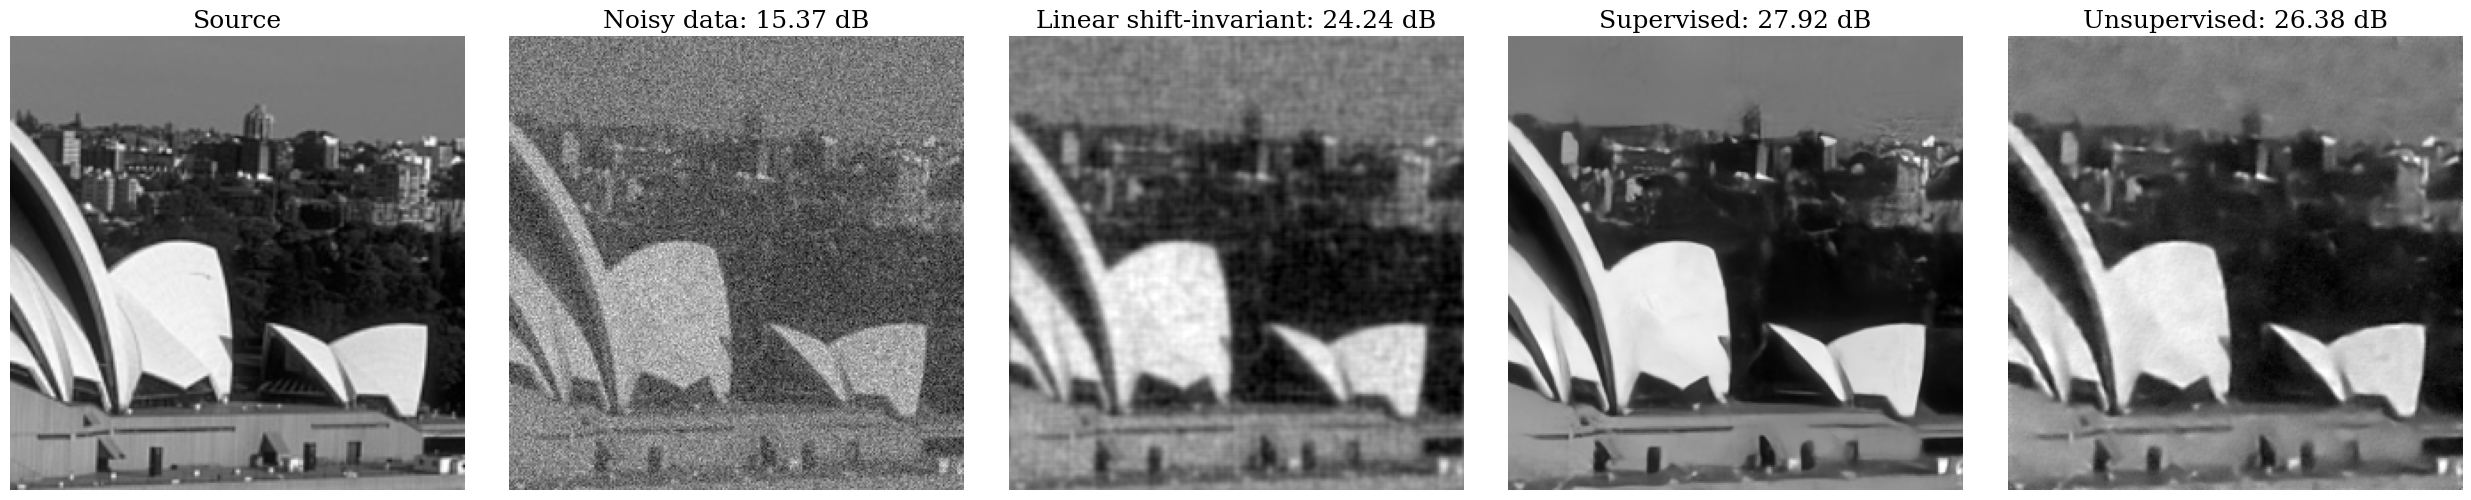

In [ ]:
# Select image from the validation set and apply models
idx = 5
noise_std = 0.17
image = val_dataset[idx]
plot_and_compare(image,noise_std, supervised_model, unsupervised_model, LSI_filter, fft_sample = (256, 256))